In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# imports
from lib import pullCitibikeData
import numpy as np
from scipy import stats
import pylab as pl

In [3]:
winter = pullCitibikeData(['01', '02']) # Pull Jan and Feb for winter
spring = pullCitibikeData(['05', '06']) # Pull May and Jun for spring

In [4]:
winter_age = 2015 - winter['birth year'][~np.isnan(winter['birth year'])]
spring_age = 2015 - spring['birth year'][~np.isnan(spring['birth year'])]

In [5]:
# Run KS Test
print "winter:", stats.kstest(winter_age, 'norm', args=(winter_age.mean(), winter_age.std()))
print "spring:", stats.kstest(spring_age, 'norm', args=(spring_age.mean(), spring_age.std()))

winter: (0.087141421563927679, 0.0)
spring: (0.10279431743035716, 0.0)


The KS test is saying that the ages for winter and spring are not _terribly_ far from normal, but significant enough, and gives a p-value of 0 for the null hypothesis that they from the normal distribution.  The winter values are slightly closer to normal

In [6]:
def plotDF(dist, title, compareDist, label):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    hist, bin_edges = np.histogram(dist, bins=50, range=(0,dist.max()))
    bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) * .5

    l1 = ax1.plot(bin_centers, hist, label="Sample PDF")
    l2 = ax2.plot(bin_centers, np.cumsum(hist)*1./np.cumsum(hist).max(), '-r', label="Sample CDF")
    l3 = ax2.plot(bin_centers, compareDist(dist, bin_centers), '--r', label="%s CDF" % label)
    lns = l1+l2+l3

    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc=0)
    ax1.set_xlabel('Age')
    ax1.set_title(title)

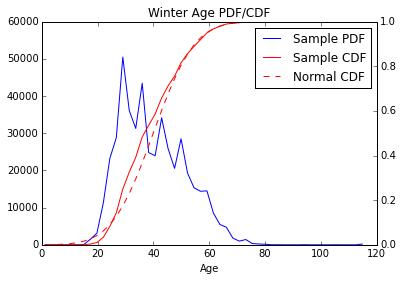

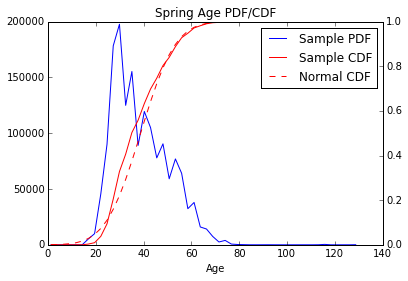

In [7]:
def normalCDF(dist, bin_centers):
    return stats.norm.cdf(bin_centers, dist.mean(), dist.std())

plotDF(winter_age, 'Winter Age PDF/CDF', normalCDF, "Normal")
plotDF(spring_age, 'Spring Age PDF/CDF', normalCDF, "Normal")

Graphing it, we confirm the results from the KS test.

In [8]:
# Define a function to run KL Divergence test
def kl(dist, m, s):
    num_bins=20
    hist, bin_edges = np.histogram(dist, bins=num_bins)
    bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) * .5
    norm = stats.norm.pdf(bin_centers, loc=m, scale=s)
    return stats.entropy(hist, norm)

In [9]:
# Run KL
print "winter:", kl(winter_age, winter_age.mean(), winter_age.std())
print "spring:", kl(spring_age, spring_age.mean(), spring_age.std())

winter: 0.0489485781678
spring: 0.0781977079236


The KL divergence test give similar results as the KS test with the two not appearing as normal, and with winter appearing slightly more normally distributed than spring.

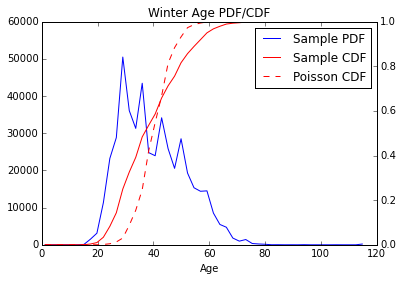

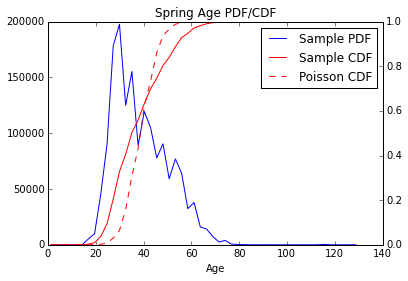

In [10]:
# How about Poisson?
def poissonCDF(dist, bin_centers):
    return stats.poisson.cdf(bin_centers, dist.mean())

plotDF(winter_age, 'Winter Age PDF/CDF', poissonCDF, "Poisson")
plotDF(spring_age, 'Spring Age PDF/CDF', poissonCDF, "Poisson")

Poisson appears to be an even worse fit

In [11]:
# Run KS Test
print "winter:", stats.kstest(winter_age, 'poisson', args=(winter_age.mean(),))
print "spring:", stats.kstest(spring_age, 'poisson', args=(spring_age.mean(),))

winter: (0.20786742991117446, 0.0)
spring: (0.21266155847573809, 0.0)


In [12]:
def kl_poisson(dist, m, s):
    bins = range(0,121,6)
    hist, bin_edges = np.histogram(dist, bins=bins)
    bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) * .5
    norm = stats.poisson.pmf(bin_centers, m)
    return stats.entropy(hist, norm)

# Run KL
print "winter:", kl_poisson(winter_age, winter_age.mean(), winter_age.std())
print "spring:", kl_poisson(spring_age, spring_age.mean(), spring_age.std())

winter: 0.607273045656
spring: 0.603551349975


Both and KS and KL tests confirm what we saw in the graph - that poisson is a worse fit for the age distribution of riders in either the spring or winter. 